# Summary: Use audio features to predict age ratings.

This notebook use `TreeRegressor` model with 13 audio features (key, acousticness, tempo, duration, etc) and popularity to predict age-ratings. 

The model achieves an $R^2$ score of 0.50, with popluarity and duration being the two most important features. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spotipy
import os
%matplotlib inline

## Track data: Features and Age Ratings

https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features

valence :
A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

In [2]:
data = pd.read_csv('../data/all.csv')

In [3]:
print (data.columns)
print (data.shape)


Index(['Age', 'Album_Name', 'Artist', 'Year', 'Description', 'Age Group',
       'Album_ID', 'Album_Name_Spotify', 'Artists_Spotify', 'Track_ID', 'ISRC',
       'Track_Name', 'Artists', 'popularity', 'preview_url', 'image_url',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'lyrics'],
      dtype='object')
(19560, 34)


In [4]:

song_features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', \
                'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', \
                'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'time_signature']

columns = ['key','mode', 'time_signature', 'duration_min','popularity', 'danceability', 'energy','loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

data['duration_min'] = data['duration_ms']/10**3/60

data = data.dropna(subset=columns)
data = data.astype({'key': 'Int64', 'mode':'Int64', 'time_signature':'Int64'})


X = data[columns]
y = list(data['Age'])

In [5]:
display(X.sample(5))

print ("Number of Tracks:" , X.shape[0])
print ("Number of Freatures:", X.shape[1])
print ("Ages: ", set(y))

,key,mode,time_signature,duration_min,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
13066,1,0,4,3.238450,53,0.354,0.895,-5.964,0.0962,0.000014,0.001460,0.1590,0.293,152.035
60,0,1,4,2.087117,53,0.764,0.460,-9.292,0.0640,0.293000,0.001560,0.2520,0.763,133.490
9499,11,0,4,3.006217,13,0.505,0.957,-3.020,0.0468,0.000727,0.000045,0.2900,0.487,130.812
14088,5,1,4,4.974450,40,0.633,0.444,-9.050,0.0255,0.760000,0.000064,0.1370,0.237,94.086
13137,4,0,4,3.648667,77,0.500,0.824,-5.846,0.0388,0.000160,0.001610,0.0916,0.539,120.125


Number of Tracks: 19527
Number of Freatures: 14
Ages:  {2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}


## Decision Tree Model

In [6]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


categorical_columns = ['key','mode', 'time_signature']

numeric_columns = ['duration_min','popularity', 'danceability', 'energy','loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

features = ColumnTransformer([
    ('categorical', OneHotEncoder(), categorical_columns),
    ('numeric', 'passthrough', numeric_columns)
])

est = Pipeline([
    ('features', features),
    ('regressor', DecisionTreeRegressor(max_depth=5) )
])

est.fit(X_train, y_train)


print ("R^2 Score: ", est.score(X_test,y_test))


# The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).
# A constant model that always predicts the expected value of y, disregarding the input features, 
# would get a  score of 0.0."

R^2 Score:  0.5021094761704463


In [7]:
from sklearn.metrics import mean_squared_error
import math
test_error = math.sqrt(mean_squared_error(y_test, est.predict(X_test)))

mean = np.mean(y_train)
baseline_error  = math.sqrt(mean_squared_error(y_test, [mean for _ in range(len(y_test))]))

print ("Base Line Model Test Error: ", baseline_error)
print ("Current Model Test Error: ", test_error)

Base Line Model Test Error:  4.825135424997403
Current Model Test Error:  3.4046751211576454


## Cross validation on  max_depth 

In [8]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


categorical_columns = ['key','mode', 'time_signature']

numeric_columns = ['duration_min','popularity', 'danceability', 'energy','loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

features = ColumnTransformer([
    ('categorical', OneHotEncoder(), categorical_columns),
    ('numeric', 'passthrough', numeric_columns)
])


pipeline = Pipeline([
    ('features', features),
    ('regressor', DecisionTreeRegressor()) 
])
param_grid = {'regressor__max_depth': range(2,10)}
est = GridSearchCV(pipeline,  param_grid,  return_train_score = True)
est.fit(X_train, y_train);

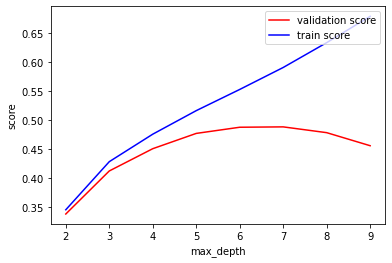

In [9]:
depth = est.param_grid['regressor__max_depth']

plt.plot(depth, est.cv_results_['mean_test_score'], c='r', label = 'validation score')
plt.plot(depth, est.cv_results_['mean_train_score'], c='b', label = 'train score')
plt.xlabel('max_depth')
plt.ylabel('score')
plt.legend(loc='upper right');

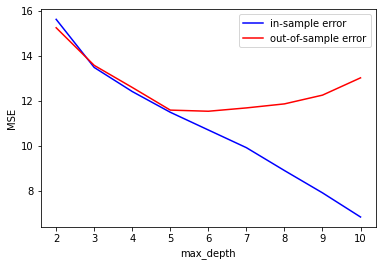

In [10]:

from sklearn import metrics
test_errors = []
in_sample_errors = []
max_depths= [2,3,4,5,6,7,8,9,10]
for max_depth in max_depths:
    model = DecisionTreeRegressor(max_depth=max_depth).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    in_sample_errors.append(metrics.mean_squared_error(y_train, y_train_pred))
    test_errors.append(metrics.mean_squared_error(y_test, y_pred))

plt.plot(max_depths, in_sample_errors, 'b-', label='in-sample error')
plt.plot(max_depths, test_errors, c='r', label='out-of-sample error')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.legend(loc='upper right');

## Feature importance

In [11]:
model = est.best_estimator_['regressor']
model.feature_importances_

array([3.93365795e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.52453163e-04, 0.00000000e+00, 0.00000000e+00, 1.39259028e-05,
       8.69839097e-04, 2.23433251e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.24844732e-03, 8.33877420e-04, 2.21512266e-01,
       4.86363526e-01, 1.02270756e-02, 6.85473571e-03, 2.57780891e-02,
       1.01106360e-01, 8.88644085e-02, 8.16689462e-03, 7.46119806e-03,
       3.30424169e-02, 4.67678848e-03])

In [16]:
est.best_estimator_['features'].get_feature_names_out()[0:10]

array(['categorical__key_0', 'categorical__key_1', 'categorical__key_2',
       'categorical__key_3', 'categorical__key_4', 'categorical__key_5',
       'categorical__key_6', 'categorical__key_7', 'categorical__key_8',
       'categorical__key_9'], dtype=object)

In [13]:
feature_names = est.best_estimator_['features'].get_feature_names()
features = [(feature_names[i], model.feature_importances_[i]) for i in range(len(feature_names))]

for feature in sorted(features, key=lambda x: -x[1]):
    print (feature)

('popularity', 0.4863635259767914)
('duration_min', 0.22151226619356706)
('speechiness', 0.10110635971046776)
('acousticness', 0.08886440846186068)
('valence', 0.03304241685961839)
('loudness', 0.02577808910180296)
('danceability', 0.010227075620263912)
('instrumentalness', 0.008166894620060506)
('liveness', 0.0074611980592236594)
('energy', 0.006854735706522058)
('tempo', 0.0046767884781645785)
('categorical__x1_1', 0.0022343325148414094)
('categorical__x2_4', 0.0012484473189348464)
('categorical__x1_0', 0.0008698390969922705)
('categorical__x2_5', 0.0008338774197275184)
('categorical__x0_0', 0.00039336579538753563)
('categorical__x0_8', 0.00035245316297959615)
('categorical__x0_11', 1.3925902793811138e-05)
('categorical__x0_1', 0.0)
('categorical__x0_2', 0.0)
('categorical__x0_3', 0.0)
('categorical__x0_4', 0.0)
('categorical__x0_5', 0.0)
('categorical__x0_6', 0.0)
('categorical__x0_7', 0.0)
('categorical__x0_9', 0.0)
('categorical__x0_10', 0.0)
('categorical__x2_0', 0.0)
('categoric

## Visualize the decision tree

### Problem with Graphviz on win10
https://stackoverflow.com/questions/35064304/runtimeerror-make-sure-the-graphviz-executables-are-on-your-systems-path-aft

In [27]:
!conda install graphviz

Solving environment: ...working... done

# All requested packages already installed.



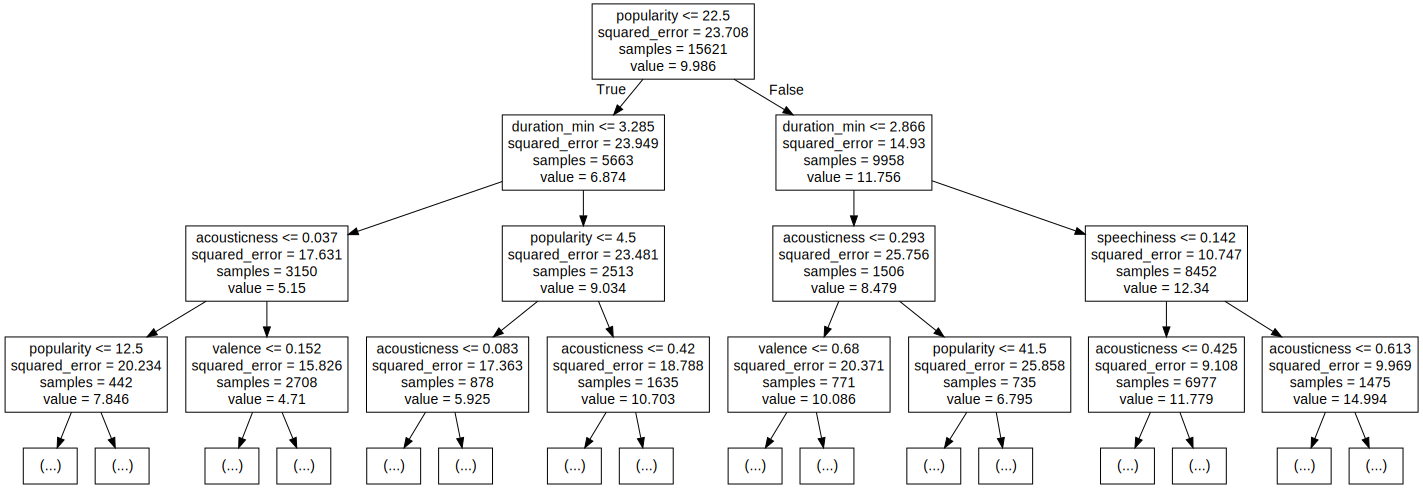

In [32]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'


import graphviz
from sklearn.tree import export_graphviz
g = graphviz.Source(export_graphviz(model, feature_names=feature_names, max_depth=3))
g

In [34]:
g.render('../figures/rating_decision_tree', format='png', quiet=True)

'..\\figures\\rating_decision_tree.png'